In [1]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import OrderedDict

# Import PyTorch
import torch # import main library
from torch.autograd import Variable
import torch.nn as nn # import modules
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters
from torch import optim # import optimizers for demonstrations
import torch.nn.functional as F # import torch functions
from torchvision import datasets, transforms # import transformations to use for demo
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters

from models.activ_func import *
from models.Nets import *
from models.test import test_img
from models.Update import *


from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2, CNNMnist3
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

import torchvision

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [31]:
class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 4  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 1 #"the number of local epochs: E"
    local_bs  = 50  #"local batch size: B"
    bs        = 50 #"test batch size"
    lr        = 0.001 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    weight_decay = 5e-4
    split     = 'user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# trainset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=args.bs, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=args.bs, shuffle=False, num_workers=2)

dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=transform_train)
dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=transform_test)
if args.iid:
    dict_users = cifar_iid(dataset_train, args.num_users)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


In [32]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

#         images.resize_(images.shape[0], 3*32*32)

        images = images.cuda()
        labels = labels.cuda()

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

# 1. Train LeNet with uncoded Dataset

In [12]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N_epochs = 50

net_glob = CNNCifar(args=args)
net_glob.cuda()

acc_test_FedAvg = np.empty(N_epochs)
loss_test_FedAvg = np.empty(N_epochs)

for iter in range(N_epochs):
    w_locals, loss_locals = [], []

    m = args.num_users
    
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    
    for idx in idxs_users:
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
        
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
#     loss_train.append(loss_avg)
    
    acc_test_FedAvg[iter] = acc_test
    loss_test_FedAvg[iter] = loss_test


Test set: Average loss: 1.6077 
Accuracy: 4660/10000 (46.60%)

Round   0, Average loss 1.536

Test set: Average loss: 1.1219 
Accuracy: 5991/10000 (59.91%)

Round   1, Average loss 1.306

Test set: Average loss: 1.0416 
Accuracy: 6298/10000 (62.98%)

Round   2, Average loss 1.177

Test set: Average loss: 0.9871 
Accuracy: 6578/10000 (65.78%)

Round   3, Average loss 1.107

Test set: Average loss: 0.9544 
Accuracy: 6708/10000 (67.08%)

Round   4, Average loss 1.060

Test set: Average loss: 0.9183 
Accuracy: 6810/10000 (68.10%)

Round   5, Average loss 1.026

Test set: Average loss: 0.8934 
Accuracy: 6858/10000 (68.58%)

Round   6, Average loss 1.004

Test set: Average loss: 0.8718 
Accuracy: 6935/10000 (69.35%)

Round   7, Average loss 0.984

Test set: Average loss: 0.8556 
Accuracy: 7036/10000 (70.36%)

Round   8, Average loss 0.967

Test set: Average loss: 0.8596 
Accuracy: 6992/10000 (69.92%)

Round   9, Average loss 0.955

Test set: Average loss: 0.8473 
Accuracy: 7060/10000 (70.60

# 2. BACC without grouping

# 2.1. K=2

In [33]:
class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 2  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 5 #"the number of local epochs: E"
    local_bs  = 50  #"local batch size: B"
    bs        = 50 #"test batch size"
    lr        = 0.001 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    weight_decay = 5e-4
    split     = 'user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# trainset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=args.bs, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=args.bs, shuffle=False, num_workers=2)

dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=transform_train)
dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=transform_test)
if args.iid:
    dict_users = cifar_iid(dataset_train, args.num_users)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


In [53]:
encoding_input_array_np = np.empty((len(dataset_train),32*32*3))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(50000/args.num_users)


for i in range(args.num_users):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        
#         print(np.size(images_np))
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,32*32*3))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np
    
print(np.shape(encoding_label_array_np))

avg_power = np.sum(encoding_input_array_np*encoding_input_array_np, axis=1)/np.shape(encoding_input_array_np)[1]
avg_power = np.sum(avg_power)/np.shape(encoding_input_array_np)[0]
print(avg_power)

size of X: (50000, 3072)
size of Y: (50000, 10)
(50000, 10)
2.0725500337056313


# K=2, T=3, w/o inPowerAlignment

In [8]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 2
T = 3
sigma = 0.1
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2]
B_array = [0.5]

N_trials = 1
N_epochs = 50

lr_array = [0.001] # 0.001 is the bset

sigma_array = [0.1, 0.3, 1]
# lr_array = [0.1, 0.01, 0.005, 0.001,0.0005]


loss_test_arr_K2_G1_v3 = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))
acc_test_arr_K2_G1_v3  = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))

N = 2
for sigma_idx in range(len(sigma_array)):
    
    sigma = sigma_array[sigma_idx]
    
    print('\n\n')
    print('sigma =',sigma)
    print('\n\n')
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print('Learning Rate =',args.lr)
        print('\n\n')
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
        z_array = np.array([-0.81, 0.81])
        
        print('z_array:',z_array)
        if sigma != 0:
            for j in range(len(z_array)):
                print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))

        
        _Noise_label = np.ones((25000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNCifar(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, sigma, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                     w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)


                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K2_G1_v3[sigma_idx][lr_idx][trial_idx][iter] = acc_test
                loss_test_arr_K2_G1_v3[sigma_idx][lr_idx][trial_idx][iter] = loss_test
                
#                 PATH = "./save_models/CIFAR10_LeNet_BACC_woPowerAlign_K2_sigma_E50_iter"+str(iter)+".pt"
#                 torch.save(net_glob.state_dict(), PATH)
                
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)




sigma = 0.1



Learning Rate = 0.001



z_array: [-0.81  0.81]
2.3175440334168256
2.317544033416827
@BACC_Enc: N,K,T, m_i= 2 2 3 25000 

@BACC_Enc: N,K,T, m_i= 2 2 3 25000 

(T, sigma)= 3 0.1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 1.9010 
Accuracy: 3314/10000 (33.14%)

Round   0, Average loss 1.901 Test accuracy 33.140
selected users: [0 1]

Test set: Average loss: 1.6722 
Accuracy: 4233/10000 (42.33%)

Round   1, Average loss 1.672 Test accuracy 42.330
selected users: [0 1]

Test set: Average loss: 1.6410 
Accuracy: 4415/10000 (44.15%)

Round   2, Average loss 1.641 Test accuracy 44.150
selected users: [0 1]

Test set: Average loss: 1.6058 
Accuracy: 4589/10000 (45.89%)

Round   3, Average loss 1.606 Test accuracy 45.890
selected users: [0 1]

Test set: Average loss: 1.5672 
Accuracy: 4804/10000 (48.04%)

Round   4, Average loss 1.567 Test accuracy 48.040
selected users: [0 1]

Test set: Average loss: 1.5435 
Accuracy: 4888/10000 (48.88%)

Round   5, Averag


Test set: Average loss: 1.4908 
Accuracy: 5145/10000 (51.45%)

Round   7, Average loss 1.491 Test accuracy 51.450
selected users: [0 1]

Test set: Average loss: 1.4913 
Accuracy: 5146/10000 (51.46%)

Round   8, Average loss 1.491 Test accuracy 51.460
selected users: [0 1]

Test set: Average loss: 1.5006 
Accuracy: 5148/10000 (51.48%)

Round   9, Average loss 1.501 Test accuracy 51.480
selected users: [0 1]

Test set: Average loss: 1.4943 
Accuracy: 5144/10000 (51.44%)

Round  10, Average loss 1.494 Test accuracy 51.440
selected users: [0 1]

Test set: Average loss: 1.4802 
Accuracy: 5204/10000 (52.04%)

Round  11, Average loss 1.480 Test accuracy 52.040
selected users: [0 1]

Test set: Average loss: 1.4951 
Accuracy: 5153/10000 (51.53%)

Round  12, Average loss 1.495 Test accuracy 51.530
selected users: [0 1]

Test set: Average loss: 1.5064 
Accuracy: 5099/10000 (50.99%)

Round  13, Average loss 1.506 Test accuracy 50.990
selected users: [0 1]

Test set: Average loss: 1.5009 
Accuracy


Test set: Average loss: 1.6358 
Accuracy: 4464/10000 (44.64%)

Round  16, Average loss 1.636 Test accuracy 44.640
selected users: [0 1]

Test set: Average loss: 1.6550 
Accuracy: 4392/10000 (43.92%)

Round  17, Average loss 1.655 Test accuracy 43.920
selected users: [0 1]

Test set: Average loss: 1.6443 
Accuracy: 4409/10000 (44.09%)

Round  18, Average loss 1.644 Test accuracy 44.090
selected users: [0 1]

Test set: Average loss: 1.6348 
Accuracy: 4484/10000 (44.84%)

Round  19, Average loss 1.635 Test accuracy 44.840
selected users: [0 1]

Test set: Average loss: 1.6350 
Accuracy: 4469/10000 (44.69%)

Round  20, Average loss 1.635 Test accuracy 44.690
selected users: [0 1]

Test set: Average loss: 1.6432 
Accuracy: 4413/10000 (44.13%)

Round  21, Average loss 1.643 Test accuracy 44.130
selected users: [0 1]

Test set: Average loss: 1.6476 
Accuracy: 4394/10000 (43.94%)

Round  22, Average loss 1.648 Test accuracy 43.940
selected users: [0 1]

Test set: Average loss: 1.6357 
Accuracy

# K=2, T=3, w/ inPowerAlignment

In [54]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 2
T = 3
sigma = 0.1
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2]
B_array = [0.5]

N_trials = 1
N_epochs = 50

lr_array = [0.001] # 0.001 is the bset

sigma_array = [0.1,0.3,1]
# lr_array = [0.1, 0.01, 0.005, 0.001,0.0005]


loss_test_arr_K2_G1_powerAlign = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))
acc_test_arr_K2_G1_powerAlign  = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))

N = 2
for sigma_idx in range(len(sigma_array)):
    
    sigma = sigma_array[sigma_idx]
    
    print('\n\n')
    print('sigma =',sigma)
    print('\n\n')
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print('Learning Rate =',args.lr)
        print('\n\n')
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
        z_array = np.array([-0.81, 0.81])
        
        print('z_array:',z_array)
        if sigma != 0:
            for j in range(len(z_array)):
                print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))

        
        _Noise_label = np.ones((25000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        print("Adjust the power of X_tilde")
        
        for p_idx in range(N):
            tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
            tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
            print(p_idx, tmp_power)
            
            X_tilde[p_idx,:,:] = X_tilde[p_idx,:,:] * np.sqrt(avg_power/tmp_power)
            tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
            tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
            print('power after adjusting =',tmp_power)
        print()
        
        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNCifar(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, sigma, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                     w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K2_G1_powerAlign[sigma_idx][lr_idx][trial_idx][iter] = acc_test
                loss_test_arr_K2_G1_powerAlign[sigma_idx][lr_idx][trial_idx][iter] = loss_test
                
#                 PATH = "./save_models/CIFAR10_LeNet_BACC_PowerAlign_K2_sigma_E50_iter"+str(iter)+".pt"
#                 torch.save(net_glob.state_dict(), PATH)
                
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)




sigma = 0.1



Learning Rate = 0.001



z_array: [-0.81  0.81]
2.3175440334168256
2.317544033416827
@BACC_Enc: N,K,T, m_i= 2 2 3 25000 

@BACC_Enc: N,K,T, m_i= 2 2 3 25000 

Adjust the power of X_tilde
0 0.41072267777558713
power after adjusting = 2.0725500337056313
1 0.41129426227703575
power after adjusting = 2.0725500337056317

(T, sigma)= 3 0.1 )  0 -th Trial!!
selected users: [0 1]

Test set: Average loss: 2.1024 
Accuracy: 3673/10000 (36.73%)

Round   0, Average loss 2.102 Test accuracy 36.730
selected users: [0 1]

Test set: Average loss: 1.6246 
Accuracy: 5641/10000 (56.41%)

Round   1, Average loss 1.625 Test accuracy 56.410
selected users: [0 1]

Test set: Average loss: 1.5448 
Accuracy: 5992/10000 (59.92%)

Round   2, Average loss 1.545 Test accuracy 59.920
selected users: [0 1]

Test set: Average loss: 1.5263 
Accuracy: 6083/10000 (60.83%)

Round   3, Average loss 1.526 Test accuracy 60.830
selected users: [0 1]

Test set: Average loss: 1.5090 
Accuracy: 6125/10000 (61.2


Test set: Average loss: 1.5451 
Accuracy: 5799/10000 (57.99%)

Round   5, Average loss 1.545 Test accuracy 57.990
selected users: [0 1]

Test set: Average loss: 1.5431 
Accuracy: 5895/10000 (58.95%)

Round   6, Average loss 1.543 Test accuracy 58.950
selected users: [0 1]

Test set: Average loss: 1.5400 
Accuracy: 5957/10000 (59.57%)

Round   7, Average loss 1.540 Test accuracy 59.570
selected users: [0 1]

Test set: Average loss: 1.5266 
Accuracy: 5926/10000 (59.26%)

Round   8, Average loss 1.527 Test accuracy 59.260
selected users: [0 1]

Test set: Average loss: 1.5364 
Accuracy: 5971/10000 (59.71%)

Round   9, Average loss 1.536 Test accuracy 59.710
selected users: [0 1]

Test set: Average loss: 1.5320 
Accuracy: 5970/10000 (59.70%)

Round  10, Average loss 1.532 Test accuracy 59.700
selected users: [0 1]

Test set: Average loss: 1.5371 
Accuracy: 5928/10000 (59.28%)

Round  11, Average loss 1.537 Test accuracy 59.280
selected users: [0 1]

Test set: Average loss: 1.5339 
Accuracy


Test set: Average loss: 1.6918 
Accuracy: 4628/10000 (46.28%)

Round  13, Average loss 1.692 Test accuracy 46.280
selected users: [0 1]

Test set: Average loss: 1.6815 
Accuracy: 4660/10000 (46.60%)

Round  14, Average loss 1.682 Test accuracy 46.600
selected users: [0 1]

Test set: Average loss: 1.6910 
Accuracy: 4591/10000 (45.91%)

Round  15, Average loss 1.691 Test accuracy 45.910
selected users: [0 1]

Test set: Average loss: 1.6931 
Accuracy: 4643/10000 (46.43%)

Round  16, Average loss 1.693 Test accuracy 46.430
selected users: [0 1]

Test set: Average loss: 1.7034 
Accuracy: 4596/10000 (45.96%)

Round  17, Average loss 1.703 Test accuracy 45.960
selected users: [0 1]

Test set: Average loss: 1.6899 
Accuracy: 4693/10000 (46.93%)

Round  18, Average loss 1.690 Test accuracy 46.930
selected users: [0 1]

Test set: Average loss: 1.6896 
Accuracy: 4647/10000 (46.47%)

Round  19, Average loss 1.690 Test accuracy 46.470
selected users: [0 1]

Test set: Average loss: 1.7005 
Accuracy

# Differential Privacy (Gaussian Noise)

In [46]:
encoding_input_array_np = np.empty((len(dataset_train),32*32*3))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(50000/args.num_users)

sigma = 0.1

for i in range(args.num_users):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        
#         print(np.size(images_np))
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,32*32*3)) 
#         encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,32*32*3)) + np.random.normal(0,sigma,size=(Size_submatrices,32*32*3))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np
    
print(np.shape(encoding_label_array_np))

avg_power = np.sum(encoding_input_array_np*encoding_input_array_np, axis=1)/np.shape(encoding_input_array_np)[1]
avg_power = np.sum(avg_power)/np.shape(encoding_input_array_np)[0]
print(avg_power)

size of X: (50000, 3072)
size of Y: (50000, 10)
(50000, 10)
2.0729636636110373


In [59]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 2
N_trials = 1
N_epochs = 50

lr_array = [0.00005] # 0.001 is the bset

sigma_array = [0.1,0.3,1]
# lr_array = [0.1, 0.01, 0.005, 0.001,0.0005]


loss_test_arr_K2_DP_v1 = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))
acc_test_arr_K2_DP_v1  = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))


for sigma_idx in range(len(sigma_array)):
    
    sigma = sigma_array[sigma_idx]
    
    print('\n\n')
    print('sigma =',sigma)
    print('\n\n')
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print('Learning Rate =',args.lr)
        print('\n\n')
        
        X_tilde = np.reshape(encoding_input_array_np, (N,Size_submatrices, 32*32*3)) + np.random.normal(0,sigma,size=(N,Size_submatrices, 32*32*3))
        y_tilde = np.reshape(encoding_label_array_np, (N,Size_submatrices, 10))

#         X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
#         y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
#         print("Adjust the power of X_tilde")
        
#         for p_idx in range(N):
#             tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
#             tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
#             print(p_idx, tmp_power)
            
#             X_tilde[p_idx,:,:] = X_tilde[p_idx,:,:] * np.sqrt(avg_power/tmp_power)
#             tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
#             tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
#             print('power after adjusting =',tmp_power)
#         print()
        
        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(sigma, lr)=',sigma,args.lr,') ',trial_idx,'-th Trial!!')

            net_glob = CNNCifar(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                
                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])
             
                                
                w_glob = copy.deepcopy(w_locals[0])
                for k in w_glob.keys():
                    for G_idx in range(1,N):
                        w_glob[k] += w_locals[G_idx][k]
                    w_glob[k] = torch.div(w_glob[k], N)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K2_DP_v1[sigma_idx][lr_idx][trial_idx][iter] = acc_test
                loss_test_arr_K2_DP_v1[sigma_idx][lr_idx][trial_idx][iter] = loss_test
                
#                 PATH = "./save_models/CIFAR10_LeNet_BACC_PowerAlign_K2_sigma_E50_iter"+str(iter)+".pt"
#                 torch.save(net_glob.state_dict(), PATH)
                
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)




sigma = 0.1



Learning Rate = 5e-05



(sigma, lr)= 0.1 5e-05 )  0 -th Trial!!

Test set: Average loss: 1.7073 
Accuracy: 3840/10000 (38.40%)

Round   0, Average loss 1.707 Test accuracy 38.400

Test set: Average loss: 1.5744 
Accuracy: 4267/10000 (42.67%)

Round   1, Average loss 1.574 Test accuracy 42.670

Test set: Average loss: 1.5049 
Accuracy: 4593/10000 (45.93%)

Round   2, Average loss 1.505 Test accuracy 45.930

Test set: Average loss: 1.4592 
Accuracy: 4785/10000 (47.85%)

Round   3, Average loss 1.459 Test accuracy 47.850

Test set: Average loss: 1.4230 
Accuracy: 4936/10000 (49.36%)

Round   4, Average loss 1.423 Test accuracy 49.360

Test set: Average loss: 1.3922 
Accuracy: 5037/10000 (50.37%)

Round   5, Average loss 1.392 Test accuracy 50.370

Test set: Average loss: 1.3661 
Accuracy: 5144/10000 (51.44%)

Round   6, Average loss 1.366 Test accuracy 51.440

Test set: Average loss: 1.3430 
Accuracy: 5221/10000 (52.21%)

Round   7, Average loss 1.343 Test accuracy 52.2


Test set: Average loss: 1.2706 
Accuracy: 5511/10000 (55.11%)

Round  20, Average loss 1.271 Test accuracy 55.110

Test set: Average loss: 1.2662 
Accuracy: 5506/10000 (55.06%)

Round  21, Average loss 1.266 Test accuracy 55.060

Test set: Average loss: 1.2622 
Accuracy: 5523/10000 (55.23%)

Round  22, Average loss 1.262 Test accuracy 55.230

Test set: Average loss: 1.2588 
Accuracy: 5539/10000 (55.39%)

Round  23, Average loss 1.259 Test accuracy 55.390

Test set: Average loss: 1.2554 
Accuracy: 5548/10000 (55.48%)

Round  24, Average loss 1.255 Test accuracy 55.480

Test set: Average loss: 1.2524 
Accuracy: 5558/10000 (55.58%)

Round  25, Average loss 1.252 Test accuracy 55.580

Test set: Average loss: 1.2492 
Accuracy: 5579/10000 (55.79%)

Round  26, Average loss 1.249 Test accuracy 55.790

Test set: Average loss: 1.2462 
Accuracy: 5588/10000 (55.88%)

Round  27, Average loss 1.246 Test accuracy 55.880

Test set: Average loss: 1.2441 
Accuracy: 5586/10000 (55.86%)

Round  28, Avera


Test set: Average loss: 1.3593 
Accuracy: 5240/10000 (52.40%)

Round  41, Average loss 1.359 Test accuracy 52.400

Test set: Average loss: 1.3601 
Accuracy: 5235/10000 (52.35%)

Round  42, Average loss 1.360 Test accuracy 52.350

Test set: Average loss: 1.3604 
Accuracy: 5233/10000 (52.33%)

Round  43, Average loss 1.360 Test accuracy 52.330

Test set: Average loss: 1.3617 
Accuracy: 5247/10000 (52.47%)

Round  44, Average loss 1.362 Test accuracy 52.470

Test set: Average loss: 1.3629 
Accuracy: 5253/10000 (52.53%)

Round  45, Average loss 1.363 Test accuracy 52.530

Test set: Average loss: 1.3651 
Accuracy: 5244/10000 (52.44%)

Round  46, Average loss 1.365 Test accuracy 52.440

Test set: Average loss: 1.3672 
Accuracy: 5230/10000 (52.30%)

Round  47, Average loss 1.367 Test accuracy 52.300

Test set: Average loss: 1.3681 
Accuracy: 5232/10000 (52.32%)

Round  48, Average loss 1.368 Test accuracy 52.320

Test set: Average loss: 1.3706 
Accuracy: 5221/10000 (52.21%)

Round  49, Avera

In [27]:
import pickle

filehandler = open("./plot/CIFAR10_LeNet_K2_N2_FedAvg","wb")
pickle.dump(acc_test_FedAvg,filehandler)
filehandler = open("./plot/CIFAR10_LeNet_K2_N2_T3_G1","wb")
pickle.dump(acc_test_arr_K2_G1_v3,filehandler)
filehandler = open("./plot/CIFAR10_LeNet_K2_N2_T3_G1_PowerAlign","wb")
pickle.dump(acc_test_arr_K2_G1_powerAlign,filehandler)

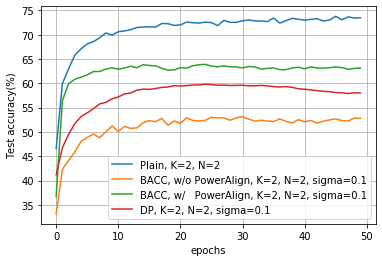

In [62]:
# lr_array = [0.1, 0.01, 0.005, 0.001,0.0005]

plt.plot(acc_test_FedAvg, label='Plain, K=2, N=2')
plt.plot(acc_test_arr_K2_G1_v3[0,0,0,0:50],label='BACC, w/o PowerAlign, K=2, N=2, sigma=0.1' )
plt.plot(acc_test_arr_K2_G1_powerAlign[0,0,0,0:50],label='BACC, w/   PowerAlign, K=2, N=2, sigma=0.1' )
plt.plot(acc_test_arr_K2_DP[0,0,0,0:50],label='DP, K=2, N=2, sigma=0.1' )

# plt.plot(acc_test_arr_K2_G1_powerAlign[0,1,0,0:50],label='w/o Grouping, K=2, N=2, sigma=0.1, PowerAlignment' )
# plt.plot(acc_test_arr_K4_G1[0,3,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.001' )
# plt.plot(acc_test_arr_K4_G1[0,4,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.0005' )


# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 2.2. K=2, T=0 (without noise)

In [99]:
# K=2
# T=3
# j_array = np.array(range(K+T))
# alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print(alpha_array)

print(alpha_array[Signal_Alloc])

print(z_array)

print(dec_z_array)

print(idxs_users)

[-0.58778525  0.58778525]
[-0.81, 0.81]
[-0.81]
[0 1]


In [101]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 2
T = 0
sigma = 1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
# alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
alpha_array = np.array([-5.87785252e-01, 5.87785252e-01])
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2]

lr_array = [0.001, 0.0003, 0.0001, 0.00003] # 0.001 is the bset


B_array = [0.5]

N_trials = 1
N_epochs = 10



loss_test_arr_K2_G1_T0_v1 = np.zeros((len(N_array),len(lr_array),N_trials,N_epochs))
acc_test_arr_K2_G1_T0_v1  = np.zeros((len(N_array),len(lr_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print('Learning Rate =',args.lr)
        print('\n\n')
        
        
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
        i_array = np.array(range(N))
#         z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
        z_array = [-0.81, 0.81]
#         z_array = alpha_array - 0.05
        
        print('z_array:',z_array)
#         for j in range(len(z_array)):
#             print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNCifar(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
#                 coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
                    print('local update, idx=',idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                print('dec z_array=',dec_z_array)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K2_G1_T0_v1[N_idx][lr_idx][trial_idx][iter] = acc_test
                loss_test_arr_K2_G1_T0_v1[N_idx][lr_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

Learning Rate = 0.001



z_array: [-0.81, 0.81]
@BACC_Enc: N,K,T, m_i= 2 2 0 25000 

@BACC_Enc: N,K,T, m_i= 2 2 0 25000 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 5634018.6192 
Accuracy: 861/10000 (8.61%)

Round   0, Average loss 5634018.619 Test accuracy 8.610
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 57287201.1812 
Accuracy: 1474/10000 (14.74%)

Round   1, Average loss 57287201.181 Test accuracy 14.740
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 314855690.2992 
Accuracy: 1928/10000 (19.28%)

Round   2, Average loss 314855690.299 Test accuracy 19.280
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 1074226853.8176 
Accuracy: 2011/10000 (20.11%)

Round   3, Average loss 

local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 3.4327 
Accuracy: 4168/10000 (41.68%)

Round   5, Average loss 3.433 Test accuracy 41.680
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 5.2844 
Accuracy: 4118/10000 (41.18%)

Round   6, Average loss 5.284 Test accuracy 41.180
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 8.6784 
Accuracy: 4085/10000 (40.85%)

Round   7, Average loss 8.678 Test accuracy 40.850
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 14.4921 
Accuracy: 4011/10000 (40.11%)

Round   8, Average loss 14.492 Test accuracy 40.110
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 24.2211 
Accuracy: 4057/10000 (40.57%)

Round   9, Average loss 24.221 Test accuracy 40.570


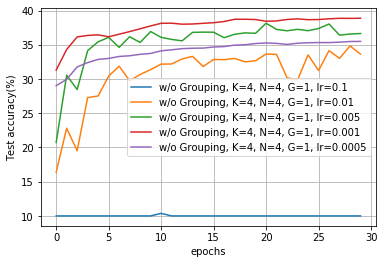

In [50]:
# lr_array = [0.1, 0.01, 0.005, 0.001,0.0005]

plt.plot(acc_test_arr_K4_G1[0,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.1' )
plt.plot(acc_test_arr_K4_G1[0,1,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.01' )
plt.plot(acc_test_arr_K4_G1[0,2,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.005' )
plt.plot(acc_test_arr_K4_G1[0,3,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.001' )
plt.plot(acc_test_arr_K4_G1[0,4,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.0005' )


# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

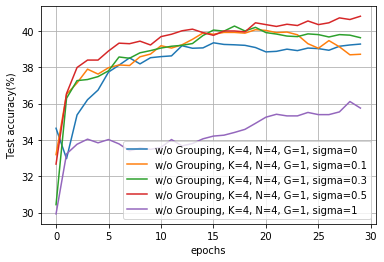

In [56]:
plt.plot(acc_test_arr_K4_G1_v1[0,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=0' )
plt.plot(acc_test_arr_K4_G1_v1[1,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=0.1' )
plt.plot(acc_test_arr_K4_G1_v1[2,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=0.3' )
plt.plot(acc_test_arr_K4_G1_v1[3,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=0.5' )
plt.plot(acc_test_arr_K4_G1_v1[4,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=1' )


# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

## 2.2. K=4

In [2]:
class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 4  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 5 #"the number of local epochs: E"
    local_bs  = 50  #"local batch size: B"
    bs        = 50 #"test batch size"
    lr        = 0.0001 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    weight_decay = 5e-4
    split     = 'user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# trainset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=args.bs, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=args.bs, shuffle=False, num_workers=2)

dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=transform_train)
dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=transform_test)
if args.iid:
    dict_users = cifar_iid(dataset_train, args.num_users)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


In [3]:
encoding_input_array_np = np.empty((len(dataset_train),32*32*3))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(50000/args.num_users)


for i in range(args.num_users):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        
#         print(np.size(images_np))
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,32*32*3))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np
    
print(np.shape(encoding_label_array_np))

avg_power = np.sum(encoding_input_array_np*encoding_input_array_np, axis=1)/np.shape(encoding_input_array_np)[1]
avg_power = np.sum(avg_power)/np.shape(encoding_input_array_np)[0]
print(avg_power)

size of X: (50000, 3072)
size of Y: (50000, 10)
(50000, 10)
2.071376214594275


In [18]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 4
T = 5
# sigma = 0.1
Noise_Alloc = [0,2,4,6,8]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [4]
lr_array = [0.001]
sigma_array = [0.1, 0.3, 1]

N_trials = 1
N_epochs = 50

N = 4

loss_test_arr_K4_G1 = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))
acc_test_arr_K4_G1  = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))

for sigma_idx in range(len(sigma_array)):
    
    
    
    sigma = sigma_array[sigma_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print('Learning Rate =',args.lr)
        print('\n\n')
        
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
        z_array = np.array([-0.94, -0.125, 0.125, 0.94])
        
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        
        print("Adjust the power of X_tilde")
        
        for p_idx in range(N):
            tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
            tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
            print(p_idx, tmp_power)
            
            X_tilde[p_idx,:,:] = X_tilde[p_idx,:,:] * np.sqrt(avg_power/tmp_power)
            tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
            tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
            print('power after adjusting =',tmp_power)
        print()
        
        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNCifar(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, sigma, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                     w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_G1[sigma_idx][lr_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_G1[sigma_idx][lr_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

Learning Rate = 0.001



z_array: [-0.94  -0.125  0.125  0.94 ]
2.21641645756389
2.3227453960929183
2.3227453960929143
2.2164164575638967
@BACC_Enc: N,K,T, m_i= 4 4 5 12500 

@BACC_Enc: N,K,T, m_i= 4 4 5 12500 

Adjust the power of X_tilde
0 0.37594425519342023
power after adjusting = 2.073207572302197
1 0.5520716062908136
power after adjusting = 2.0732075723021977
2 0.5522205126489026
power after adjusting = 2.0732075723021977
3 0.3753727500517572
power after adjusting = 2.0732075723021977

(T, sigma)= 5 0.1 )  0 -th Trial!!
selected users: [0 1 2 3]

Test set: Average loss: 2.2002 
Accuracy: 2535/10000 (25.35%)

Round   0, Average loss 2.200 Test accuracy 25.350
selected users: [0 1 2 3]

Test set: Average loss: 1.8854 
Accuracy: 4567/10000 (45.67%)

Round   1, Average loss 1.885 Test accuracy 45.670
selected users: [0 1 2 3]

Test set: Average loss: 1.7508 
Accuracy: 4995/10000 (49.95%)

Round   2, Average loss 1.751 Test accuracy 49.950
selected users: [0 1 2 3]

Test set: Average 


Test set: Average loss: 1.8488 
Accuracy: 4701/10000 (47.01%)

Round   1, Average loss 1.849 Test accuracy 47.010
selected users: [0 1 2 3]

Test set: Average loss: 1.7441 
Accuracy: 4980/10000 (49.80%)

Round   2, Average loss 1.744 Test accuracy 49.800
selected users: [0 1 2 3]

Test set: Average loss: 1.7110 
Accuracy: 5161/10000 (51.61%)

Round   3, Average loss 1.711 Test accuracy 51.610
selected users: [0 1 2 3]

Test set: Average loss: 1.6893 
Accuracy: 5258/10000 (52.58%)

Round   4, Average loss 1.689 Test accuracy 52.580
selected users: [0 1 2 3]

Test set: Average loss: 1.6655 
Accuracy: 5356/10000 (53.56%)

Round   5, Average loss 1.666 Test accuracy 53.560
selected users: [0 1 2 3]

Test set: Average loss: 1.6523 
Accuracy: 5430/10000 (54.30%)

Round   6, Average loss 1.652 Test accuracy 54.300
selected users: [0 1 2 3]

Test set: Average loss: 1.6436 
Accuracy: 5469/10000 (54.69%)

Round   7, Average loss 1.644 Test accuracy 54.690
selected users: [0 1 2 3]

Test set: Av


Test set: Average loss: 1.7174 
Accuracy: 4312/10000 (43.12%)

Round   6, Average loss 1.717 Test accuracy 43.120
selected users: [0 1 2 3]

Test set: Average loss: 1.7104 
Accuracy: 4382/10000 (43.82%)

Round   7, Average loss 1.710 Test accuracy 43.820
selected users: [0 1 2 3]

Test set: Average loss: 1.7012 
Accuracy: 4393/10000 (43.93%)

Round   8, Average loss 1.701 Test accuracy 43.930
selected users: [0 1 2 3]

Test set: Average loss: 1.6972 
Accuracy: 4359/10000 (43.59%)

Round   9, Average loss 1.697 Test accuracy 43.590
selected users: [0 1 2 3]

Test set: Average loss: 1.6956 
Accuracy: 4351/10000 (43.51%)

Round  10, Average loss 1.696 Test accuracy 43.510
selected users: [0 1 2 3]

Test set: Average loss: 1.6969 
Accuracy: 4350/10000 (43.50%)

Round  11, Average loss 1.697 Test accuracy 43.500
selected users: [0 1 2 3]

Test set: Average loss: 1.6926 
Accuracy: 4376/10000 (43.76%)

Round  12, Average loss 1.693 Test accuracy 43.760
selected users: [0 1 2 3]

Test set: Av

# 2.3. K=4, N=4, T=3, G=2, with grouping

In [4]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

G = 2
N = 4 # N should be divisible by G
K = 4 # N should be divisible by G

size_per_group = int(50000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,32*32*3))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, 0.81])

B = 0.5

N_trials = 1

N_epochs = 50

lr_array = [0.0005]

sigma_array = [0.1]

loss_test_arr_K4_G2_alignment_v1 = np.zeros((len(sigma_array),len(lr_array),N_epochs))
acc_test_arr_K4_G2_alignment_v1  = np.zeros((len(sigma_array),len(lr_array),N_epochs))


for sigma_idx in range(len(sigma_array)):
    
    sigma = sigma_array[sigma_idx]
    print('##########################################')
    print('Sigma =',sigma)
    print('\n\n')
    
    for lr_idx in range(len(lr_array)):

        args.lr = lr_array[lr_idx]

        print('##########################################')
        print('Learning Rate =',args.lr)
        print('\n\n')

    #     print('##########################################')
    #     print('######',trial_idx,'-th Trial!! ###########')

        net_glob = CNNCifar(args=args)
        net_glob.cuda()
        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()

        X_tilde = np.empty((N,Size_submatrices,32*32*3))
        y_tilde = np.empty((N,Size_submatrices,10))

        for G_idx in range(G):

            _Noise_label = np.ones((size_per_group*T,10)) * 0.1

            X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
            y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

            stt_pos = G_idx * N_i
            end_pos = (G_idx+1) * N_i

            X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
            y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp


        print("Adjust the power of X_tilde")

        for p_idx in range(N):
            tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
            tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
            print(p_idx, tmp_power)

            X_tilde[p_idx,:,:] = X_tilde[p_idx,:,:] * np.sqrt(avg_power/tmp_power)
            tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
            tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
            print('power after adjusting =',tmp_power)
        print()



        for iter in range(N_epochs): #args.epochs

            w_group_array = []
            for G_idx in range(G):
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N_i), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)

                coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
    #                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                w_group_array.append(copy.deepcopy(w_group))

            w_glob = copy.deepcopy(w_group_array[0])
            for k in w_glob.keys():
                for G_idx in range(1,G):
                    w_glob[k] += w_group_array[G_idx][k]
                w_glob[k] = torch.div(w_glob[k], len(w_group_array))

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
        #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

        #     loss_train_arr.append(loss_train)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            
            print(sigma_idx,lr_idx,iter)
            acc_test_arr_K4_G2_alignment_v1[sigma_idx][lr_idx][iter] = acc_test
            loss_test_arr_K4_G2_alignment_v1[sigma_idx][lr_idx][iter] = loss_test

            if iter % 1 ==0:
                print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))

        
        
    

2 2 3
##########################################
Sigma = 0.1



##########################################
Learning Rate = 0.0005



@BACC_Enc: N,K,T, m_i= 2 2 3 12500 

@BACC_Enc: N,K,T, m_i= 2 2 3 12500 

@BACC_Enc: N,K,T, m_i= 2 2 3 12500 

@BACC_Enc: N,K,T, m_i= 2 2 3 12500 

Adjust the power of X_tilde
0 0.40958203262854803
power after adjusting = 2.071376214594275
1 0.41082296921406597
power after adjusting = 2.0713762145942756
2 0.4104500250991252
power after adjusting = 2.0713762145942756
3 0.4118166059656703
power after adjusting = 2.0713762145942747

selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 2.0329 
Accuracy: 3907/10000 (39.07%)

0 0 0
Round   0, Average loss 2.033 Test accuracy 39.070
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 1.7706 
Accuracy: 4676/10000 (46.76%)

0 0 1
Round   1, Average loss 1.771 Test accuracy 46.760
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 1.7172 
Accuracy: 5021/10000 (50.2

selected users: [0 1]

Test set: Average loss: 1.5606 
Accuracy: 5925/10000 (59.25%)

0 0 46
Round  46, Average loss 1.561 Test accuracy 59.250
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 1.5605 
Accuracy: 5922/10000 (59.22%)

0 0 47
Round  47, Average loss 1.561 Test accuracy 59.220
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 1.5586 
Accuracy: 5914/10000 (59.14%)

0 0 48
Round  48, Average loss 1.559 Test accuracy 59.140
selected users: [0 1]
selected users: [0 1]

Test set: Average loss: 1.5585 
Accuracy: 5919/10000 (59.19%)

0 0 49
Round  49, Average loss 1.558 Test accuracy 59.190


In [22]:
print(np.shape(acc_test_arr_K4_G2_alignment))

(3, 1, 1, 50)


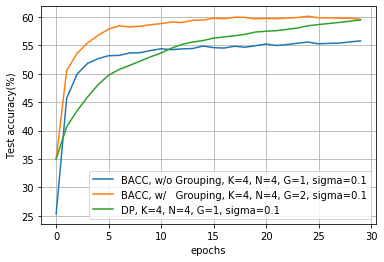

In [73]:
plt.plot(acc_test_arr_K4_G1[0,0,0,0:30],label='BACC, w/o Grouping, K=4, N=4, G=1, sigma=0.1' )
plt.plot(acc_test_arr_K4_G2_alignment[0,0,0:30],label='BACC, w/   Grouping, K=4, N=4, G=2, sigma=0.1' )
plt.plot(acc_test_arr_K4_DP[0,0,0,0:30],label='DP, K=4, N=4, G=1, sigma=0.1' )


# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 2.4. DP

In [68]:
Size_submatrices

12500

In [5]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N = 4
N_trials = 1
N_epochs = 50

lr_array = [0.0003] # 0.001 is the bset

sigma_array = [0.1, 0.3, 1]
# lr_array = [0.1, 0.01, 0.005, 0.001,0.0005]


loss_test_arr_K4_DP = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))
acc_test_arr_K4_DP  = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))


for sigma_idx in range(len(sigma_array)):
    
    sigma = sigma_array[sigma_idx]
    
    print('\n\n')
    print('sigma =',sigma)
    print('\n\n')
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print('Learning Rate =',args.lr)
        print('\n\n')
        
        X_tilde = np.reshape(encoding_input_array_np, (N,Size_submatrices, 32*32*3)) + np.random.normal(0,sigma,size=(N,Size_submatrices, 32*32*3))
        y_tilde = np.reshape(encoding_label_array_np, (N,Size_submatrices, 10))

#         X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
#         y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
#         print("Adjust the power of X_tilde")
        
#         for p_idx in range(N):
#             tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
#             tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
#             print(p_idx, tmp_power)
            
#             X_tilde[p_idx,:,:] = X_tilde[p_idx,:,:] * np.sqrt(avg_power/tmp_power)
#             tmp_power = np.sum(X_tilde[p_idx,:,:] * X_tilde[p_idx,:,:], axis=1)/np.shape(X_tilde)[2]
#             tmp_power = np.sum(tmp_power)/np.shape(X_tilde)[1]
#             print('power after adjusting =',tmp_power)
#         print()
        
        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(sigma, lr)=',sigma,args.lr,') ',trial_idx,'-th Trial!!')

            net_glob = CNNCifar(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))
            
                                
                w_glob = copy.deepcopy(w_locals[0])
                for k in w_glob.keys():
                    for G_idx in range(1,N):
                        w_glob[k] += w_locals[G_idx][k]
                    w_glob[k] = torch.div(w_glob[k], N)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_DP[sigma_idx][lr_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_DP[sigma_idx][lr_idx][trial_idx][iter] = loss_test
                
#                 PATH = "./save_models/CIFAR10_LeNet_BACC_PowerAlign_K2_sigma_E50_iter"+str(iter)+".pt"
#                 torch.save(net_glob.state_dict(), PATH)
                
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)




sigma = 0.1



Learning Rate = 0.0003



(sigma, lr)= 0.1 0.0003 )  0 -th Trial!!

Test set: Average loss: 1.5887 
Accuracy: 4313/10000 (43.13%)

Round   0, Average loss 1.589 Test accuracy 43.130

Test set: Average loss: 1.4099 
Accuracy: 4933/10000 (49.33%)

Round   1, Average loss 1.410 Test accuracy 49.330

Test set: Average loss: 1.3399 
Accuracy: 5184/10000 (51.84%)

Round   2, Average loss 1.340 Test accuracy 51.840

Test set: Average loss: 1.2889 
Accuracy: 5394/10000 (53.94%)

Round   3, Average loss 1.289 Test accuracy 53.940

Test set: Average loss: 1.2524 
Accuracy: 5512/10000 (55.12%)

Round   4, Average loss 1.252 Test accuracy 55.120

Test set: Average loss: 1.2267 
Accuracy: 5593/10000 (55.93%)

Round   5, Average loss 1.227 Test accuracy 55.930

Test set: Average loss: 1.2107 
Accuracy: 5654/10000 (56.54%)

Round   6, Average loss 1.211 Test accuracy 56.540

Test set: Average loss: 1.2037 
Accuracy: 5715/10000 (57.15%)

Round   7, Average loss 1.204 Test accuracy 57


Test set: Average loss: 1.5798 
Accuracy: 5646/10000 (56.46%)

Round  20, Average loss 1.580 Test accuracy 56.460

Test set: Average loss: 1.6431 
Accuracy: 5645/10000 (56.45%)

Round  21, Average loss 1.643 Test accuracy 56.450

Test set: Average loss: 1.7001 
Accuracy: 5619/10000 (56.19%)

Round  22, Average loss 1.700 Test accuracy 56.190

Test set: Average loss: 1.7627 
Accuracy: 5577/10000 (55.77%)

Round  23, Average loss 1.763 Test accuracy 55.770

Test set: Average loss: 1.8168 
Accuracy: 5561/10000 (55.61%)

Round  24, Average loss 1.817 Test accuracy 55.610

Test set: Average loss: 1.8846 
Accuracy: 5532/10000 (55.32%)

Round  25, Average loss 1.885 Test accuracy 55.320

Test set: Average loss: 1.9452 
Accuracy: 5528/10000 (55.28%)

Round  26, Average loss 1.945 Test accuracy 55.280

Test set: Average loss: 2.0059 
Accuracy: 5500/10000 (55.00%)

Round  27, Average loss 2.006 Test accuracy 55.000

Test set: Average loss: 2.0463 
Accuracy: 5476/10000 (54.76%)

Round  28, Avera


Test set: Average loss: 2.8710 
Accuracy: 4693/10000 (46.93%)

Round  41, Average loss 2.871 Test accuracy 46.930

Test set: Average loss: 2.9543 
Accuracy: 4661/10000 (46.61%)

Round  42, Average loss 2.954 Test accuracy 46.610

Test set: Average loss: 2.9567 
Accuracy: 4703/10000 (47.03%)

Round  43, Average loss 2.957 Test accuracy 47.030

Test set: Average loss: 3.0076 
Accuracy: 4697/10000 (46.97%)

Round  44, Average loss 3.008 Test accuracy 46.970

Test set: Average loss: 3.0940 
Accuracy: 4687/10000 (46.87%)

Round  45, Average loss 3.094 Test accuracy 46.870

Test set: Average loss: 3.1386 
Accuracy: 4652/10000 (46.52%)

Round  46, Average loss 3.139 Test accuracy 46.520

Test set: Average loss: 3.1243 
Accuracy: 4719/10000 (47.19%)

Round  47, Average loss 3.124 Test accuracy 47.190

Test set: Average loss: 3.1903 
Accuracy: 4680/10000 (46.80%)

Round  48, Average loss 3.190 Test accuracy 46.800

Test set: Average loss: 3.2656 
Accuracy: 4675/10000 (46.75%)

Round  49, Avera

In [6]:
K = 2
T = 3
sigma = 0.1
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))

print(alpha_array)

[ 9.51056516e-01  5.87785252e-01  6.12323400e-17 -5.87785252e-01
 -9.51056516e-01]
